In [ ]:
!pip -q install ultralytics opencv-python matplotlib pandas

from ultralytics import YOLO
import cv2, numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib.patches as patches
from google.colab import files

model = YOLO('yolo11n.pt')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Saving img5.jpg to img5.jpg


Text(0.5, 1.0, 'Original')

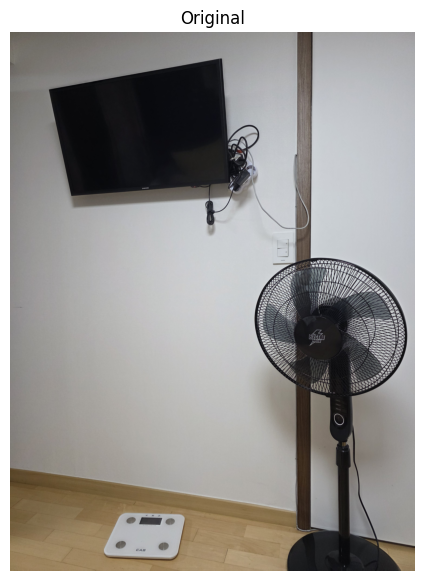

In [ ]:
uploaded = files.upload()
fname = list(uploaded.keys())[0]

img_bgr = cv2.imdecode(np.frombuffer(uploaded[fname], np.uint8), cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,7)); plt.imshow(img_rgb); plt.axis('off'); plt.title('Original')


In [ ]:
results = model.predict(source=img_rgb, conf=0.35, iou=0.5, imgsz=1280, verbose=False)
r = results[0]
boxes = r.boxes
names = r.names


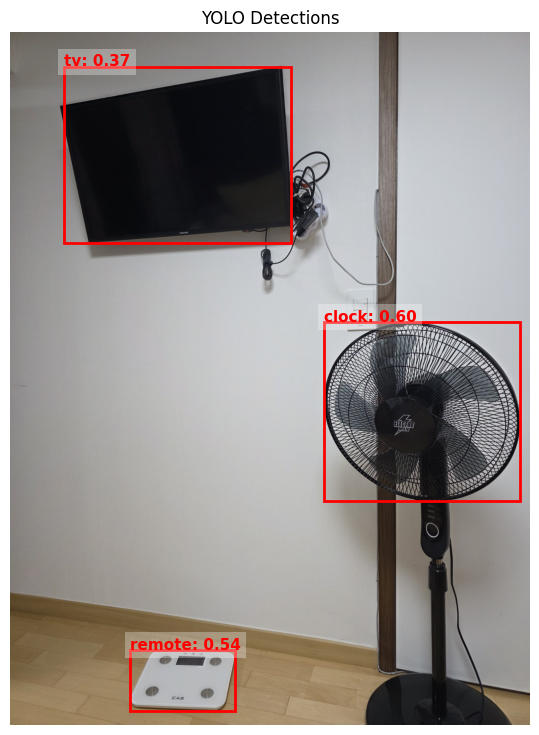

탐지 이미지 저장: detections.png


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,9))
ax.imshow(img_rgb); ax.axis('off')

records = []
if boxes is not None and len(boxes) > 0:
    for b in boxes:
        x1, y1, x2, y2 = b.xyxy.squeeze().tolist()
        cls  = int(b.cls.squeeze().item())
        conf = float(b.conf.squeeze().item())
        ax.add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                       linewidth=2, edgecolor='red', facecolor='none'))
        ax.text(x1, max(0,y1-5), f"{names[cls]}: {conf:.2f}",
                color='red', fontsize=11, weight='bold',
                bbox=dict(facecolor='white', alpha=0.3, edgecolor='none'))
        records.append([names[cls], conf, x1, y1, x2, y2])

plt.title('YOLO Detections')
plt.savefig('detections.png', dpi=150, bbox_inches='tight')
plt.show()

print("탐지 이미지 저장: detections.png")


In [ ]:
df = pd.DataFrame(records, columns=['class','conf','x1','y1','x2','y2']).sort_values('conf', ascending=False)
display(df[['class','conf']])
display(df['class'].value_counts().rename('count').to_frame())


,class,conf
0,clock,0.597457
1,remote,0.535487
2,tv,0.369699


,count
class,
clock,1
remote,1
tv,1


In [ ]:
import numpy as np

def iou_xyxy(a,b):
    xa1,ya1,xa2,ya2 = a; xb1,yb1,xb2,yb2 = b
    inter_w = max(0, min(xa2, xb2)-max(xa1, xb1))
    inter_h = max(0, min(ya2, yb2)-max(ya1, yb1))
    inter = inter_w*inter_h
    area_a = max(0, xa2-xa1)*max(0, ya2-ya1)
    area_b = max(0, xb2-xb1)*max(0, yb2-yb1)
    union = area_a + area_b - inter + 1e-9
    return inter/union

K = min(20, len(df))
if K>=2:
    coords = df[['x1','y1','x2','y2']].to_numpy()[:K]
    iou_mat = np.zeros((K,K))
    for i in range(K):
        for j in range(K):
            if i!=j: iou_mat[i,j] = iou_xyxy(coords[i], coords[j])
    m = iou_mat.max()
    print(f"Max IoU among top-{K}: {m:.3f} (높으면 중복 검출 의심)")


Max IoU among top-3: 0.000 (높으면 중복 검출 의심)


In [ ]:
from ultralytics import YOLO
model = YOLO('yolo11n.pt')       # COCO로 학습된 가중치
names = list(model.names.values())  # ['person', 'bicycle', ..., 'toothbrush']

print(len(names), "classes")
print(sorted(names)[:15])         # 일부만 보기

# 특정 클래스 존재 여부 체크
queries = ["fan", "wire", "cable", "light switch", "switch", "tv", "remote", "clock"]
for q in queries:
    print(f"{q:12s} ->", q in names)


80 classes
['airplane', 'apple', 'backpack', 'banana', 'baseball bat', 'baseball glove', 'bear', 'bed', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'bowl']
fan          -> False
wire         -> False
cable        -> False
light switch -> False
switch       -> False
tv           -> True
remote       -> True
clock        -> True
